In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [35]:
EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.001

In [3]:
df = pd.read_csv("../uci_data/OnlineNewsPopularity.csv")
print("calculating mean/median")
mean =  df[" shares"].mean()
median = df[" shares"].median()
print("mean: ", mean)
print("median: ", median)
[print(len(df))]

calculating mean/median
mean:  3395.3801836343455
median:  1400.0
39644


[None]

In [4]:
df.loc[df[' shares'] < median, ' shares'] = 0
df.loc[df[' shares'] >= median, ' shares'] = 1
df = df.iloc[:, 2:]

In [5]:
df.head()
len(df.columns)

59

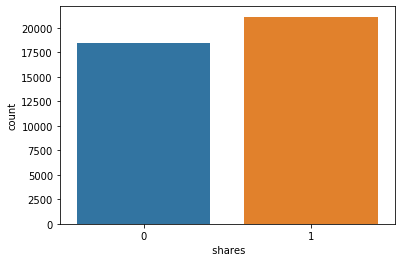

In [6]:
sns.countplot(x = ' shares', data=df)

In [7]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [24]:
X

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.378636,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.286915,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.495833,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.385965,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.411127,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,1.0,4.523121,...,0.333791,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000
39640,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,48.0,4.405488,...,0.374825,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000
39641,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,1.0,5.076923,...,0.307273,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364
39642,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,0.0,4.975073,...,0.236851,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000


In [26]:
y


0        0
1        0
2        1
3        0
4        0
        ..
39639    1
39640    1
39641    1
39642    0
39643    0
Name:  shares, Length: 39644, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [10]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [36]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [37]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 58.
        self.layer_1 = nn.Linear(58, 256) 
        self.layer_2 = nn.Linear(256, 256)
        self.layer_out = nn.Linear(256, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(256)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [39]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=58, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=256, bias=True)
  (layer_out): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [40]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [41]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.63757 | Acc: 64.010
Epoch 002: | Loss: 0.60674 | Acc: 66.885
Epoch 003: | Loss: 0.59701 | Acc: 67.462
Epoch 004: | Loss: 0.58944 | Acc: 68.154
Epoch 005: | Loss: 0.58121 | Acc: 69.038
Epoch 006: | Loss: 0.57605 | Acc: 69.452
Epoch 007: | Loss: 0.56404 | Acc: 70.433
Epoch 008: | Loss: 0.55749 | Acc: 70.644
Epoch 009: | Loss: 0.54868 | Acc: 71.721
Epoch 010: | Loss: 0.53723 | Acc: 72.413
Epoch 011: | Loss: 0.52949 | Acc: 73.269
Epoch 012: | Loss: 0.52144 | Acc: 73.433
Epoch 013: | Loss: 0.50741 | Acc: 74.433
Epoch 014: | Loss: 0.49246 | Acc: 75.654
Epoch 015: | Loss: 0.48350 | Acc: 76.288
Epoch 016: | Loss: 0.46815 | Acc: 77.192
Epoch 017: | Loss: 0.45305 | Acc: 78.231
Epoch 018: | Loss: 0.43542 | Acc: 79.365
Epoch 019: | Loss: 0.42385 | Acc: 80.144
Epoch 020: | Loss: 0.41265 | Acc: 80.635
Epoch 021: | Loss: 0.40024 | Acc: 81.337
Epoch 022: | Loss: 0.38058 | Acc: 82.635
Epoch 023: | Loss: 0.37165 | Acc: 82.971
Epoch 024: | Loss: 0.35237 | Acc: 84.202
Epoch 025: | Los

In [42]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [43]:
confusion_matrix(y_test, y_pred_list)


array([[3531, 2476],
       [2662, 4414]])

In [44]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       0.57      0.59      0.58      6007
           1       0.64      0.62      0.63      7076

    accuracy                           0.61     13083
   macro avg       0.61      0.61      0.61     13083
weighted avg       0.61      0.61      0.61     13083

